In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

print("Tensorflow:", tf.__version__)
print("Keras:", keras.__version__)

Sun Apr  5 03:32:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
#model = keras.models.load_model('/content/gdrive/My Drive/image-segmentation/unet_people_augmented.hdf5')
model = keras.models.load_model('/content/gdrive/My Drive/image-segmentation/unet_people_variable_augmented.hdf5')
#model = keras.models.load_model('/content/gdrive/My Drive/image-segmentation/unet_people.hdf5')

In [4]:
# Using OpenCV to read images and convert them to arrays
import cv2

from matplotlib import pyplot as plt
import numpy as np
import os

# Scanning test image directory
# Test images can have variable dimensions as long as sides are divisible by 2 multiple times due to necessary convolutions and maxpooling kernels
# Acceptable sizes are 256 (basic dimension we trained the model with), 384, 512, 768, 1024, 1536, etc...

testDirectory = '/content/gdrive/My Drive/image-segmentation/supervisely-person-dataset/test-256-min'

fileList = os.listdir(testDirectory)

# Count images on test folder
numImages = len(fileList)

# Prepare the output
fig, axs = plt.subplots(numImages, 4,figsize=(40, numImages * 9))

for i in range(0,numImages):

  filePath = testDirectory + '/' + fileList[i]
  imageFile = cv2.imread(filePath)
  imageTensor = []
  imageTensor.append(np.array(imageFile)/255.0)
  predMask = model.predict(np.array(imageTensor))[0]

  # This is a neat trick: whilst the UNET output shape is (255,255,1), the actual image is (255,255) where each element has a value.
  # Numpy has a neat "squeeze" feature to scalarize vectors that is very efficient
  # np.squeeze([[1]]) = [1]
  testMaskImages = (np.squeeze(predMask) * 255).astype('uint8')

  # Predicted segmentation mask from the model
  axs[i, 0].imshow(testMaskImages,cmap='gray')
  axs[i, 0].set_title('Predicted Mask')

  # Binary mask (after threshold)
  binaryImages = cv2.threshold(testMaskImages,127, 255,cv2.THRESH_BINARY)[1]
  axs[i, 1].imshow(binaryImages)
  axs[i, 1].set_title('Binary Mask')

  # Read original file
  RGB_image = cv2.cvtColor(imageFile, cv2.COLOR_BGR2RGB)
  axs[i,2].imshow(RGB_image)
  axs[i, 2].set_title('Test Image')

  # Inverted binary mask to be used on background extraction
  invertedMask = cv2.bitwise_not(binaryImages)

  # White image to be used as a background. It needs the same shape as the input image
  white_bg = 255 * np.ones(shape=imageTensor[0].shape , dtype=np.uint8)

  # Resulting image with black background
  image_black_background = cv2.bitwise_or(imageFile, imageFile, mask = binaryImages)

  # White background AND inverted mask
  white_background = cv2.bitwise_and(white_bg, white_bg, mask=invertedMask)
  
  # Final image with bitwise OR
  finalImage = cv2.bitwise_or(image_black_background, white_background)

  RGB_image = cv2.cvtColor(finalImage, cv2.COLOR_BGR2RGB)
  axs[i,3].imshow(RGB_image)
  axs[i, 3].set_title('Masked Image')


Output hidden; open in https://colab.research.google.com to view.

# Just some fun using the camera to capture and segment webcam images

https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Process with UNET';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

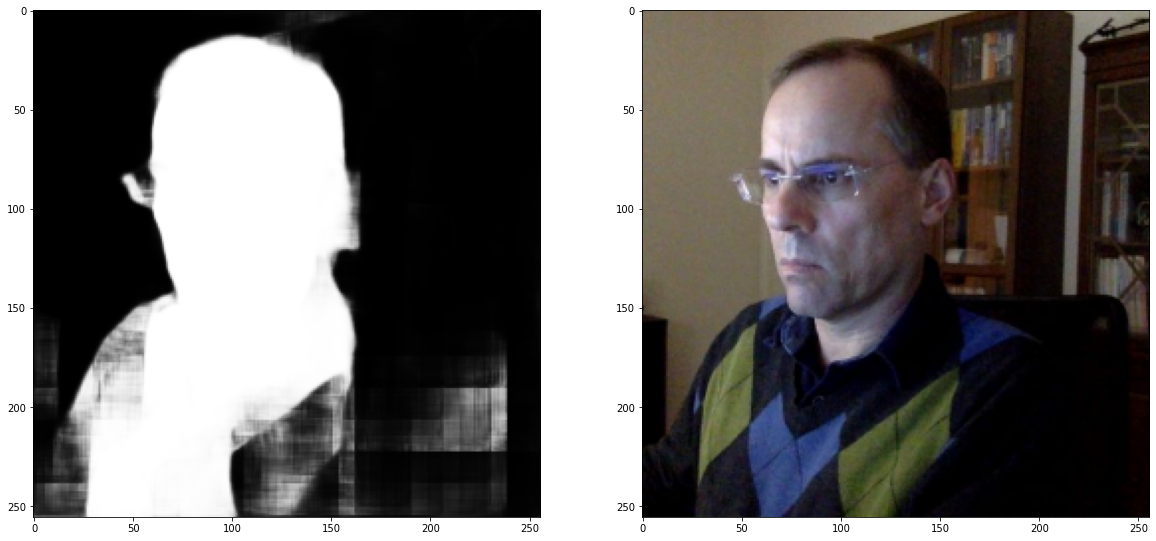

In [0]:
from IPython.display import Image
try:
  binary = take_photo()
  
  # Show the image which was just taken.
  # display(Image(binary))
  
  imageFile = cv2.imread(binary)
  crop_img = imageFile[:,80:560]
  resizedImage = cv2.resize(crop_img, (256,256), interpolation = cv2.INTER_AREA)
  RGB_image = cv2.cvtColor(resizedImage, cv2.COLOR_BGR2RGB)
  
  X = np.array(resizedImage) / 255
  Z=[]
  Z.append(X)
  Z=np.array(Z)
  testImage = np.squeeze(model.predict(Z)[0])

  fig, axs = plt.subplots(1, 2,figsize=(20,10))
  axs[0].imshow(testImage,cmap='gray')
  axs[1].imshow(RGB_image)  

except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))